In [1]:
import os

train_filepath="C:\\Users\\MSI\\Desktop\\DL\\Datasets\\FER\\train\\"
test_filepath="C:\\Users\\MSI\\Desktop\\DL\\Datasets\\FER\\test\\"

for expression in os.listdir(train_filepath):
    print(str(len(os.listdir(train_filepath + expression))) + " " + expression + " images")

3995 angry images
436 disgust images
4097 fear images
7214 happy images
4965 neutral images
4830 sad images
3171 surprise images


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF

In [3]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=7,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [4]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(7, activation='softmax'))

In [5]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3591      
Total params: 24,640,391
Trainable params: 1,052,679
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
def to_rgb(image_path):
  numpydata = np.asarray(image_path)
  img = np.expand_dims(numpydata, axis=0)
  return img

# Create a data generator
datagen_train = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    preprocessing_function=to_rgb
)  # we don't expect Bo to be upside-down so we will not flip vertically

# No need to augment validation data
datagen_valid = ImageDataGenerator(
    samplewise_center=True,
    preprocessing_function=to_rgb
)

In [7]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    train_filepath,
    target_size=(180, 180),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
)

# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    test_filepath,
    target_size=(180, 180),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True,mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2, min_lr=0.00001,model='auto')
callbacks = [PlotLossesKerasTF(),checkpoint, reduce_lr]

epochs = 10
steps_per_epoch = train_it.n//train_it.batch_size
validation_steps = valid_it.n//valid_it.batch_size

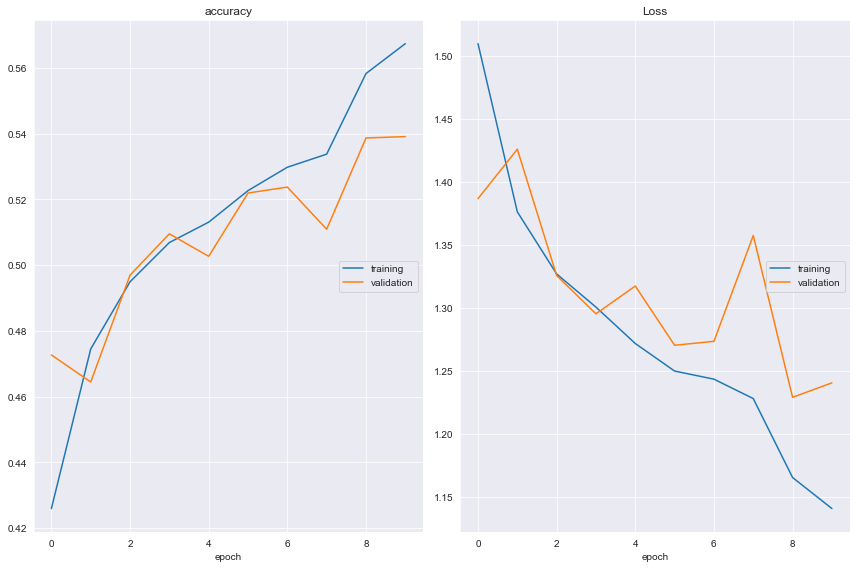

accuracy
	training         	 (min:    0.426, max:    0.567, cur:    0.567)
	validation       	 (min:    0.464, max:    0.539, cur:    0.539)
Loss
	training         	 (min:    1.141, max:    1.510, cur:    1.141)
	validation       	 (min:    1.229, max:    1.426, cur:    1.241)

Epoch 00010: saving model to model_weights.h5


In [9]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(x=train_it,steps_per_epoch=steps_per_epoch,epochs=epochs,validation_data=valid_it,validation_steps=validation_steps, callbacks=callbacks)

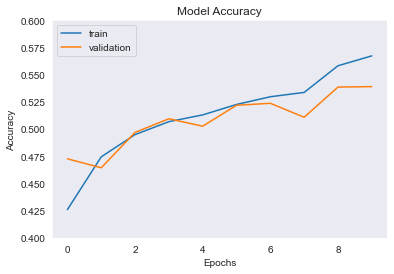

In [11]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=0.6)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [12]:
model_json = resnet_model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

C:\Users\MSI\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
